In [190]:
import sqlite3 as sql 
import pandas as pd     
import matplotlib.pyplot as plt

In [76]:
pd.set_option("display.max_columns", 50)

In [84]:
#Extract loan level data and only keep loans that started in 2018
with sql.connect("loans2018.db") as conn:
    
    query_loans_2018 = """
    SELECT
        l.loan_id,
        l.loan_start_date,
        l.lender_id,
        l.loan_amount,
        ld.lender_parent_name
    FROM loans AS l
    INNER JOIN lenders AS ld
        ON l.lender_id = ld.lender_id
    WHERE strftime('%Y', l.loan_start_date) = '2018'
    """
    
    loans_2018 = pd.read_sql(query_loans_2018, conn)

loans_2018.head(10)

,loan_id,loan_start_date,lender_id,loan_amount,lender_parent_name
0,218062,2018-05-09 00:00:00,46786,3013.54,JP Morgan
1,219576,2018-05-08 00:00:00,17729,335.62,Taiwan Financial Holding Co Ltd
2,222529,2018-01-31 00:00:00,118208,150.00,Qatar National Bank SAQ [QNB]
3,223179,2018-01-22 00:00:00,20393,514.82,PT Bank Mandiri Persero
4,223788,2018-03-22 00:00:00,31824,374.45,Sumitomo Mitsui Financial Group Inc
5,224564,2018-01-04 00:00:00,17729,253.55,Taiwan Financial Holding Co Ltd
6,224852,2018-05-31 00:00:00,16957,150.00,Fubon Financial Holding Co Ltd
7,225350,2018-01-05 00:00:00,12677,282.10,BMO Capital Markets Financing Inc
8,225890,2018-03-27 00:00:00,46801,300.00,Mitsubishi UFJ Financial Group Inc
9,225935,2018-02-08 00:00:00,23803,370.96,HSBC Banking Group


In [80]:
#Step1: Aggregate total loan amounts by parent lender

#Calculate the total amount of loans by each parent lender
lender_totals = (
    loans_2018
    .groupby("lender_parent_name", as_index=False)["loan_amount"]
    .sum()
)
#Rename the aggregated column to something descriptive
lender_totals = lender_totals.rename(
    columns={"loan_amount": "total_loan_amount"}
)

In [86]:
#Step2: Compute total market size and each lender's market share

#Check column datatypes 
lender_totals.dtypes

lender_parent_name     object
total_loan_amount     float64
market_share          float64
dtype: object

In [87]:
# Calculation
total_market_amount = lender_totals["total_loan_amount"].sum()

lender_totals["market_share"] = (
    lender_totals["total_loan_amount"] / total_market_amount * 100
)

In [128]:
# Sort lenders by total loan amount (descending)
lender_totals_sorted = lender_totals.sort_values(
    by="total_loan_amount",
    ascending=False
).reset_index(drop=True)

lender_totals_sorted.head(10)

,lender_parent_name,total_loan_amount,market_share
0,JP Morgan,372038.93,19.875833
1,BofA Securities,198703.71,10.615561
2,BNP Paribas SA,169189.21,9.038776
3,Sumitomo Mitsui Financial Group Inc,156191.18,8.344368
4,Goldman Sachs & Co,109930.69,5.872945
5,Mizuho Financial Group Inc,101233.50,5.408305
6,Mitsubishi UFJ Financial Group Inc,97139.91,5.189609
7,Citi,77622.12,4.146889
8,Wells Fargo & Co,50546.61,2.700406
9,Natixis SA,46948.59,2.508185


In [129]:
# Step 3: Extract the top 7 lender parents
top7 = lender_totals_sorted.head(7).copy()

# Rename the lender name column 
top7 = top7.rename(columns={
    "lender_parent_name": "top7_lender_parent_name"
})
# Capture which parent names are in the top 7
top7_lenders_parent = set(top7["top7_lender_parent_name"])

In [130]:
# Step 4: Aggregate all remaining lenders into "Other Lenders" row
others = lender_totals_sorted[
    ~lender_totals_sorted["lender_parent_name"].isin(top7_lenders_parent)
].copy()

# Compute totals for "Other Lenders"
other_total_amount = others["total_loan_amount"].sum()
other_total_share = others["market_share"].sum()

# Build a one-row DataFrame for "Other Lenders"
other_row = pd.DataFrame({
    "top7_lender_parent_name": ["Other Lenders"],
    "total_loan_amount": [other_total_amount],
    "market_share": [other_total_share]
})

In [131]:
# Step 7: Combine top_7_parent + "Other lenders" into final reporting table
final_table1 = pd.concat(
    [top7, other_row],
    ignore_index=True
)

In [186]:
# Sanity checks for the final summary table
YEAR = 2018
TOP_N = 7
UNIT = "millions"  # choose "millions" or "billions"

assert set(["top7_lender_parent_name","total_loan_amount","market_share"]).issubset(final_table1.columns), \
    "Expected columns missing from final_table1."

ms_sum = final_table1["market_share"].sum()
assert abs(ms_sum - 100) < 1e-6, f"Market shares sum to {ms_sum:.6f}, not 100."

assert final_table1["top7_lender_parent_name"].isna().sum() == 0, "Missing lender parent names detected."

In [187]:
#Create a table 
report_table = final_table1.rename(columns={
    "top7_lender_parent_name": "Parent Lender",
    "total_loan_amount": "Total Loan Amount (USD millions)",
    "market_share": "Market Share (%)"
}).copy()

report_table["Market Share (%)"] = report_table["Market Share (%)"].apply(
    lambda x: f"{x:.2f}%"
)

report_table["Total Loan Amount (USD millions)"] = report_table[
    "Total Loan Amount (USD millions)"
].apply(lambda x: f"${x:,.0f}")

report_table

,Parent Lender,Total Loan Amount (USD millions),Market Share (%)
0,JP Morgan,"$372,039",19.88%
1,BofA Securities,"$198,704",10.62%
2,BNP Paribas SA,"$169,189",9.04%
3,Sumitomo Mitsui Financial Group Inc,"$156,191",8.34%
4,Goldman Sachs & Co,"$109,931",5.87%
5,Mizuho Financial Group Inc,"$101,234",5.41%
6,Mitsubishi UFJ Financial Group Inc,"$97,140",5.19%
7,Other Lenders,"$667,388",35.65%


In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

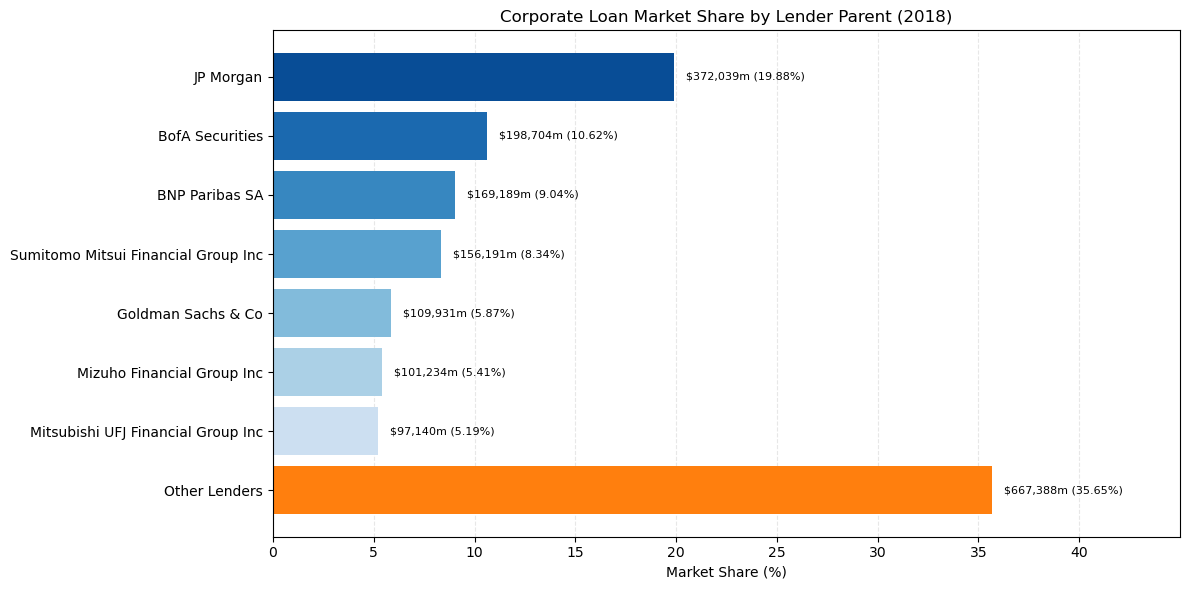

In [194]:
#Step 8: Visualising Market Composition with Horizontal Leaderboard
#Sort top 7 lenders and place "Other Lenders" last.
others = final_table1[final_table1["top7_lender_parent_name"] == "Other Lenders"]
banks  = final_table1[final_table1["top7_lender_parent_name"] != "Other Lenders"]
banks_sorted = banks.sort_values(by="market_share", ascending=False)
plot_table = pd.concat([banks_sorted, others], ignore_index=True)

# Define colors
palette = sns.color_palette("Blues", n_colors=len(plot_table))[::-1]
colors = [palette[i] if name != "Other Lenders" else "#ff7f0e"
          for i, name in enumerate(plot_table["top7_lender_parent_name"])]

# Calculate total market share of top 7 for annotation box
top7_share = banks_sorted["market_share"].sum()

# The horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(
    y=plot_table["top7_lender_parent_name"],
    width=plot_table["market_share"],
    color=colors
)

# Grid
ax.set_axisbelow(True)
ax.grid(axis="x", linestyle="--", alpha=0.3)

# Axis labels and title
ax.set_xlabel("Market Share (%)")
ax.set_ylabel("")
ax.set_title("Corporate Loan Market Share by Lender Parent (2018)")

# Format x-axis ticks
ax.set_xticks(range(0, 41, 5))
ax.set_xlim(0, 45)

ax.invert_yaxis()

# Label bars
for bar, share, amount in zip(bars,
                              plot_table["market_share"],
                              plot_table["total_loan_amount"]):
    label = f"${amount:,.0f}m ({share:.2f}%)"
    x_pos = share + 0.6  # slight offset to the right
    ax.text(x_pos,
            bar.get_y() + bar.get_height()/2,
            label,
            va="center", ha="left",
            fontsize=8, color="black")

plt.tight_layout()
plt.savefig("top7_lenders.png", dpi=300, bbox_inches="tight")
plt.show()
